In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.5.1 True
12.4
NVIDIA A40


In [2]:
import torch
torch.cuda.empty_cache()


In [3]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
#h = 1e-3  # Integration step size
h = 1e-3  # Integration step size
#h = 1e-5  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 35

# Set the diffusion coefficient
sigma = 1.09
print ('Lag time: ', lag_time)

Lag time:  0.1


In [4]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 1225/1225 [00:21<00:00, 57.56it/s]


In [5]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [6]:
# ## load the data from local folder
# import os
# # Load the data_matrix from the file
# folder_path = "data"
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# data_matrix = np.load(file_path)
# data_matrix.shape

In [7]:
!nvidia-smi

Thu Dec 12 19:59:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:57:00.0 Off |                    0 |
|  0%   33C    P0             78W /  300W |    3333MiB /  46068MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

Shape of data_X: (1225, 10, 2)
Shape of data_Y: (1225, 10, 2)
Shape of X: (12250, 2)
Shape of Y: (12250, 2)
(8575, 2)


In [9]:


checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    # 'K': Koopman_matrix_K,
    # 'Psi_X': Psi_X,
    # 'Psi_Y': Psi_Y,
    }



Epoch: 1 	Training Loss: 0.787549 val loss: 0.751753
saving, val loss enhanced: 0.7517531210342068 10000
Epoch: 2 	Training Loss: 0.706487 val loss: 0.678764
saving, val loss enhanced: 0.6787641015764413 0.7517531210342068
Epoch: 3 	Training Loss: 0.642462 val loss: 0.628422
saving, val loss enhanced: 0.6284216288907156 0.6787641015764413
Epoch: 4 	Training Loss: 0.595062 val loss: 0.587337
saving, val loss enhanced: 0.5873367220927332 0.6284216288907156
Epoch: 5 	Training Loss: 0.558404 val loss: 0.554724
saving, val loss enhanced: 0.5547240174277898 0.5873367220927332
Epoch: 6 	Training Loss: 0.526812 val loss: 0.528680
saving, val loss enhanced: 0.5286797290399614 0.5547240174277898
Epoch: 7 	Training Loss: 0.501590 val loss: 0.501894
saving, val loss enhanced: 0.5018938022358755 0.5286797290399614
Epoch: 8 	Training Loss: 0.479198 val loss: 0.481276
saving, val loss enhanced: 0.4812763673820693 0.5018938022358755
Epoch: 9 	Training Loss: 0.457281 val loss: 0.459739
saving, val loss

Computing dPsi_X: 100%|██████████| 85740/85740 [00:10<00:00, 8168.21iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_3ple_well.jbl
Outer Epoch 1/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:10<00:00, 8414.15iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.234668 val loss: 0.201738
saving, val loss enhanced: 0.20173761321395509 1000000000000000.0
Epoch: 2 	Training Loss: 0.234126 val loss: 0.201287
saving, val loss enhanced: 0.20128748278744452 0.20173761321395509
Epoch: 3 	Training Loss: 0.233590 val loss: 0.200842
saving, val loss enhanced: 0.20084160652679722 0.20128748278744452


/workspace/solver_edmd_torch_gpu_sde.py:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch: 4 	Training Loss: 0.233055 val loss: 0.200398
saving, val loss enhanced: 0.20039834246585173 0.20084160652679722
Epoch 1 time: 47.80 seconds
Outer Epoch 2/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:10<00:00, 8166.94iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.214145 val loss: 0.182108
saving, val loss enhanced: 0.1821084489724963 0.20039834246585173
Epoch: 2 	Training Loss: 0.213725 val loss: 0.181762
saving, val loss enhanced: 0.18176234216311682 0.1821084489724963
Epoch: 3 	Training Loss: 0.213303 val loss: 0.181413
saving, val loss enhanced: 0.18141263832513674 0.18176234216311682
Epoch: 4 	Training Loss: 0.212878 val loss: 0.181060
saving, val loss enhanced: 0.1810601526429386 0.18141263832513674
Epoch 2 time: 46.43 seconds
Outer Epoch 3/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 9026.75iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.196248 val loss: 0.165455
saving, val loss enhanced: 0.16545474484294564 0.1810601526429386
Epoch: 2 	Training Loss: 0.195908 val loss: 0.165176
saving, val loss enhanced: 0.16517564141699959 0.16545474484294564
Epoch: 3 	Training Loss: 0.195566 val loss: 0.164893
saving, val loss enhanced: 0.16489341251096912 0.16517564141699959
Epoch: 4 	Training Loss: 0.195221 val loss: 0.164608
saving, val loss enhanced: 0.16460835577717545 0.16489341251096912
Epoch 3 time: 46.01 seconds
Outer Epoch 4/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 8946.29iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.180842 val loss: 0.151412
saving, val loss enhanced: 0.1514122414992892 0.16460835577717545
Epoch: 2 	Training Loss: 0.180563 val loss: 0.151183
saving, val loss enhanced: 0.15118316602412132 0.1514122414992892
Epoch: 3 	Training Loss: 0.180282 val loss: 0.150952
saving, val loss enhanced: 0.15095154041079534 0.15118316602412132
Epoch: 4 	Training Loss: 0.179999 val loss: 0.150717
saving, val loss enhanced: 0.1507174504830708 0.15095154041079534
Epoch 4 time: 49.00 seconds
Outer Epoch 5/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 8725.40iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.167643 val loss: 0.139568
saving, val loss enhanced: 0.13956802167834234 0.1507174504830708
Epoch: 2 	Training Loss: 0.167409 val loss: 0.139377
saving, val loss enhanced: 0.1393765318921774 0.13956802167834234
Epoch: 3 	Training Loss: 0.167174 val loss: 0.139183
saving, val loss enhanced: 0.1391829382964573 0.1393765318921774
Epoch: 4 	Training Loss: 0.166937 val loss: 0.138987
saving, val loss enhanced: 0.13898724879861832 0.1391829382964573
Epoch 5 time: 48.79 seconds
Outer Epoch 6/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 9086.55iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.156379 val loss: 0.129574
saving, val loss enhanced: 0.12957408899218456 0.13898724879861832
Epoch: 2 	Training Loss: 0.156179 val loss: 0.129411
saving, val loss enhanced: 0.12941090295771446 0.12957408899218456
Epoch: 3 	Training Loss: 0.155979 val loss: 0.129246
saving, val loss enhanced: 0.12924597153098208 0.12941090295771446
Epoch: 4 	Training Loss: 0.155776 val loss: 0.129079
saving, val loss enhanced: 0.12907927629123056 0.12924597153098208
Epoch 6 time: 46.31 seconds


/workspace/solver_edmd_torch_gpu_sde.py:684: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


In [10]:
print (solver.L_Psi.shape, solver.dPsi_X.shape, solver.data_x_train[:-1, :].shape, solver.data_y_train.shape, solver.Psi_X.shape)

torch.Size([10, 10]) torch.Size([8574, 10]) (8574, 2) (8575, 2) torch.Size([8575, 10])


(10,)
[1.00000048 0.99632188 0.88738781 0.5720361  0.55499293 0.3910349
 0.28557312 0.08438792 0.04887011 0.00772693]


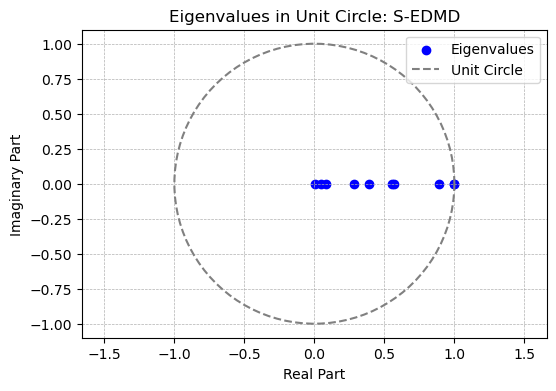

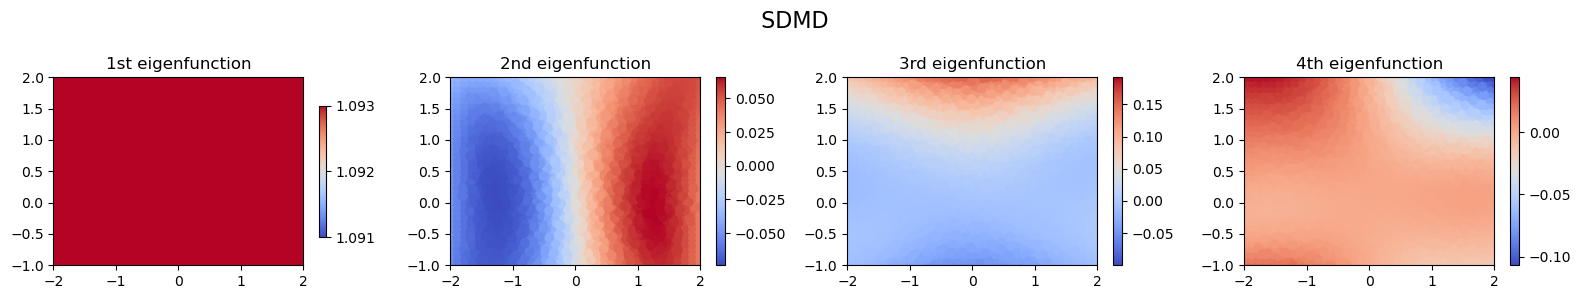

In [11]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: S-EDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' SDMD ', fontsize=16)
plt.tight_layout()
plt.show()


In [12]:
checkpoint_file_g= 'well2d_example_ckpt004_g.torch'

basis_function_g = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver_g = KoopmanSolverTorch_g(dic=basis_function_g, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file_g, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32)

solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_gedmd
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()


outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
#    'K': Koopman_matrix_K,
    # 'Psi_X': Psi_X,
    # 'Psi_Y': Psi_Y,
    }



Precomputed SDE coefficients loaded from: a_b_example_3ple_well.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9576.12iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Outer Epoch 1/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 10190.98iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9769.51iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:03<00:00, 10665.09iteration/s]


Epoch: 1 	Training Loss: 14.937341 val loss: 35.449912
saving, val loss enhanced: 35.44991238655861 1000000000000000.0
Epoch: 2 	Training Loss: 14.902802 val loss: 35.401706
saving, val loss enhanced: 35.40170601049453 35.44991238655861


/workspace/solver_gedmd_torch_gpu.py:309: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch: 3 	Training Loss: 14.869421 val loss: 35.355048
saving, val loss enhanced: 35.35504836128997 35.40170601049453
Epoch: 4 	Training Loss: 14.836365 val loss: 35.309157
saving, val loss enhanced: 35.30915718560148 35.35504836128997
Epoch 1 time: 103.89 seconds
Outer Epoch 2/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 9200.11iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 10299.42iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:03<00:00, 11293.33iteration/s]


Epoch: 1 	Training Loss: 14.757038 val loss: 35.008757
saving, val loss enhanced: 35.00875710113921 35.30915718560148
Epoch: 2 	Training Loss: 14.725648 val loss: 34.965443
saving, val loss enhanced: 34.96544330906487 35.00875710113921
Epoch: 3 	Training Loss: 14.694351 val loss: 34.922274
saving, val loss enhanced: 34.92227424563816 34.96544330906487
Epoch: 4 	Training Loss: 14.663117 val loss: 34.879231
saving, val loss enhanced: 34.879231169326516 34.92227424563816
Epoch 2 time: 105.80 seconds
Outer Epoch 3/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:07<00:00, 11133.26iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9787.00iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:04<00:00, 8826.83iteration/s]


Epoch: 1 	Training Loss: 14.581258 val loss: 34.598557
saving, val loss enhanced: 34.59855670184919 34.879231169326516
Epoch: 2 	Training Loss: 14.551352 val loss: 34.557393
saving, val loss enhanced: 34.55739269921493 34.59855670184919
Epoch: 3 	Training Loss: 14.521511 val loss: 34.516278
saving, val loss enhanced: 34.516277775602994 34.55739269921493
Epoch: 4 	Training Loss: 14.491707 val loss: 34.475210
saving, val loss enhanced: 34.4752104941373 34.516277775602994
Epoch 3 time: 106.00 seconds
Outer Epoch 4/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:07<00:00, 10926.01iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:07<00:00, 11000.37iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:03<00:00, 9303.64iteration/s]


Epoch: 1 	Training Loss: 14.413651 val loss: 34.219950
saving, val loss enhanced: 34.21995016038965 34.4752104941373
Epoch: 2 	Training Loss: 14.385019 val loss: 34.180510
saving, val loss enhanced: 34.1805095060865 34.21995016038965
Epoch: 3 	Training Loss: 14.356441 val loss: 34.141093
saving, val loss enhanced: 34.1410933434627 34.1805095060865
Epoch: 4 	Training Loss: 14.327889 val loss: 34.101700
saving, val loss enhanced: 34.10170009260722 34.1410933434627
Epoch 4 time: 109.40 seconds
Outer Epoch 5/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 10058.24iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9864.42iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:03<00:00, 9234.41iteration/s]


Epoch: 1 	Training Loss: 14.252812 val loss: 33.869229
saving, val loss enhanced: 33.86922858288095 34.10170009260722
Epoch: 2 	Training Loss: 14.225316 val loss: 33.831289
saving, val loss enhanced: 33.83128902362126 33.86922858288095
Epoch: 3 	Training Loss: 14.197867 val loss: 33.793364
saving, val loss enhanced: 33.793363934334614 33.83128902362126
Epoch: 4 	Training Loss: 14.170438 val loss: 33.755451
saving, val loss enhanced: 33.75545069913181 33.793363934334614
Epoch 5 time: 110.12 seconds
Outer Epoch 6/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:07<00:00, 11056.44iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 10327.42iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:03<00:00, 11591.88iteration/s]


Epoch: 1 	Training Loss: 14.097252 val loss: 33.541602
saving, val loss enhanced: 33.541602264950335 33.75545069913181
Epoch: 2 	Training Loss: 14.070787 val loss: 33.505008
saving, val loss enhanced: 33.505008348905655 33.541602264950335


/workspace/solver_gedmd_torch_gpu.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


Epoch: 3 	Training Loss: 14.044363 val loss: 33.468423
saving, val loss enhanced: 33.4684234894621 33.505008348905655
Epoch: 4 	Training Loss: 14.017954 val loss: 33.431844
saving, val loss enhanced: 33.43184429729479 33.4684234894621
Epoch 6 time: 105.34 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9879.90iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0


(10,)
[2.75536145-1.65239917j 2.75536145+1.65239917j 1.46089593-1.49655216j
 1.46089593+1.49655216j 1.74283242+0.j         1.32498039+0.j
 1.0501083 +0.j         1.        +0.j         0.91042886+0.j
 0.54058421+0.j        ]


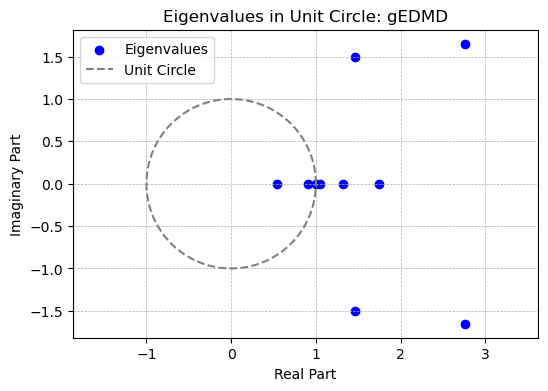

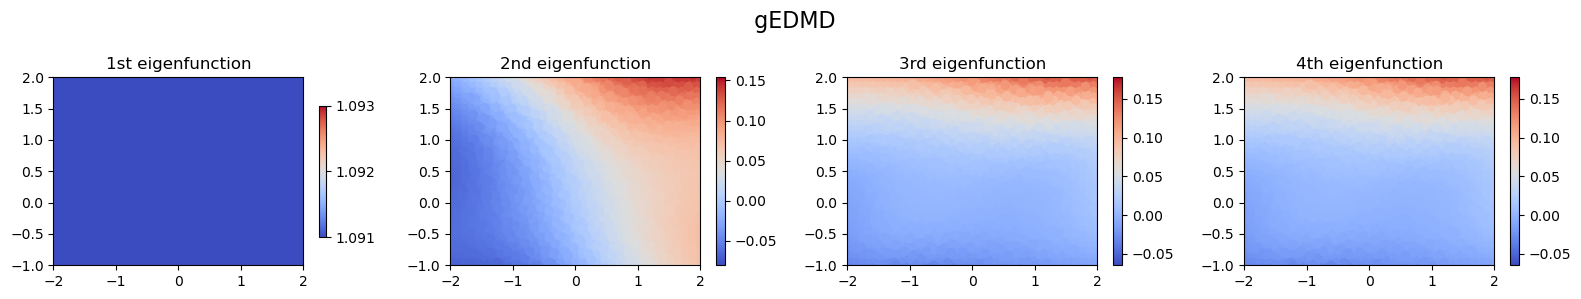

In [13]:
#computing eigenvalues of K from generator eigenvalues using exponetnt
#eigenfunctions are the same for the operator and the generator
evalues= np.exp(evalues)

# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data
# Assuming evalues is a numpy array of complex numbers

print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()
